## Importing Relevant Libraries

#### General

In [1]:
import pandas as pd
import numpy as np

#### For clustering

In [28]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

#### For principal component analysis

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#### For plotting

In [4]:
import matplotlib.pyplot as plt

# =============================================================

# 1. Reading in the data

# =============================================================

### Read in data from PVL-Delta model

In [5]:
df_pvl_delta = pd.read_csv("./data/parameter_igt_pvl_delta.csv")

#### Inspect the data

In [6]:
df_pvl_delta.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver
0,young,1,0.159011,0.487522,0.686815,0.954498
1,young,2,0.064666,0.511008,1.391790,0.295529
2,young,3,0.113089,0.465141,0.918734,0.533232
3,young,4,0.089273,0.500391,0.703737,0.869859
4,young,5,0.233898,0.488053,0.897867,0.511095


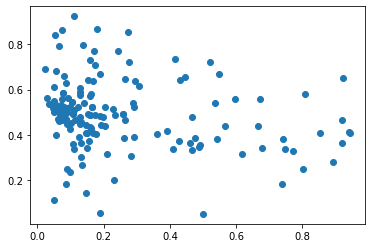

In [7]:
plt.scatter(df_pvl_delta["LR"], df_pvl_delta["Outcome_Sens"])

#### Processing
'SubID' column can be dropped as it is not used for analysis.

In [8]:
df_pvl_delta.drop(columns=['SubID'], inplace=True)

In [9]:
df_pvl_delta.head()

,group,LR,Outcome_Sens,Response_cons,Loss_Aver
0,young,0.159011,0.487522,0.686815,0.954498
1,young,0.064666,0.511008,1.391790,0.295529
2,young,0.113089,0.465141,0.918734,0.533232
3,young,0.089273,0.500391,0.703737,0.869859
4,young,0.233898,0.488053,0.897867,0.511095


### Read in data from the ORL model

In [10]:
df_orl = pd.read_csv("./data/parameter_igt_orl.csv")

#### Inspect the data

In [11]:
df_orl.head()

,subjID,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


#### Processing
'subjID' column in input file is actually the 'group' column based on its contents. Thus, rename the column as so.

In [12]:
df_orl.rename(columns={'subjID':'group'}, inplace=True)
df_orl.head()

,group,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


### Read in data from the VPP model

In [13]:
df_vpp = pd.read_csv("./data/parameters_igt_vpp.csv")

#### Inspect the data

In [14]:
df_vpp.head()

,group,SubID,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,1,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,2,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,3,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,4,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,5,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


#### Processing
'SubID' column is dropped as done for PVL-Delta dataset.

In [15]:
df_vpp.drop(columns=['SubID'], inplace=True)
df_vpp.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


# =============================================================

# 2. Standardising the Data

# =============================================================

#### Assign which data source to use

According to Lili's paper, the best-fitting model was the VPP model so we will use this data source firstly for analysis.

In [16]:
original_df = df_vpp

#### Exclude the group column

In [17]:
train_df = original_df.iloc[:, 1:]

In [18]:
train_df.describe()

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.070824,0.560575,1.329323,0.952138,0.460940,-0.720379,0.406367,0.622995
std,0.064683,0.111139,0.198041,0.580621,1.185591,1.102656,0.187483,0.066657
min,0.027454,0.352471,0.879707,0.193857,-2.977630,-2.912838,0.042780,0.452978
25%,0.038294,0.448811,1.202790,0.528927,-0.287230,-1.634716,0.256420,0.569390
50%,0.050247,0.590334,1.316736,0.760613,0.593115,-0.779120,0.439912,0.640917
75%,0.078495,0.646090,1.428836,1.292569,1.419412,0.137599,0.565139,0.675971
max,0.617431,0.818137,1.938694,2.698527,2.559126,1.583109,0.858421,0.744017


#### Standardising the features

In [19]:
standardised_train_array = StandardScaler().fit_transform(train_df)

standardised_train_df = pd.DataFrame(standardised_train_array, columns=train_df.columns)

In [20]:
standardised_train_df.describe()

,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,153.000000,1.530000e+02,1.530000e+02,1.530000e+02,1.530000e+02,1.530000e+02,1.530000e+02,1.530000e+02
mean,0.000000,1.393221e-16,2.786442e-16,2.322035e-17,1.161018e-17,2.322035e-17,-1.393221e-16,-3.715256e-16
std,1.003284,1.003284e+00,1.003284e+00,1.003284e+00,1.003284e+00,1.003284e+00,1.003284e+00,1.003284e+00
min,-0.672716,-1.878615e+00,-2.277774e+00,-1.310273e+00,-2.909824e+00,-1.994874e+00,-1.945674e+00,-2.558982e+00
25%,-0.504571,-1.008928e+00,-6.410213e-01,-7.312885e-01,-6.331242e-01,-8.319367e-01,-8.024148e-01,-8.068266e-01
50%,-0.319165,2.686431e-01,-6.376586e-02,-3.309464e-01,1.118507e-01,-5.344755e-02,1.795116e-01,2.697515e-01
75%,0.118975,7.719602e-01,5.041357e-01,5.882480e-01,8.110895e-01,7.806565e-01,8.496451e-01,7.973600e-01
max,8.478293,2.325082e+00,3.087106e+00,3.017676e+00,1.775551e+00,2.095897e+00,2.419090e+00,1.821545e+00


#### Add the group feature back in

In [21]:
standardised_df = pd.concat([original_df.iloc[:, 0], standardised_train_df], axis=1)

In [22]:
standardised_df.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,-0.502291,0.630340,-0.618199,0.169659,-0.842824,-1.085232,1.407168,0.563691
1,young,-0.390124,0.629703,1.514082,-1.290663,-0.502920,-0.639829,0.111524,1.450305
2,young,-0.393302,0.382748,0.335619,-0.983347,-0.681861,-0.909377,0.464937,0.989304
3,young,-0.543427,0.677963,-1.324734,-0.221779,-0.584010,-0.695217,1.174449,0.797360
4,young,-0.157737,0.683369,2.399490,-1.076327,-0.911356,-1.674759,0.179512,0.490205


# Consideration of Clustering Algorithms

There are a number of clustering algorithms which we could implement. Below, we try the KMeans and Spectral Clustering algorithms and analyse how these perform on the data in question. 

To determine which algorithm is more appropriate to the dataset, we will measure their performance using the Silhouette Coefficient. The Silhouette Coefficien of a data point quantifies how similar a data point is to its own cluster compared to other clusters. We will use the mean Silhouette Coefficient across all data points to compare the performace of both algorithms.

The Silhouette Coefficient for a particular data point is calculated by the below formula:

$$(b - a) / max(a, b)$$

Where a is a measure of mean intra-cluster distance
and b is a measure of mean nearest-cluster distance
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html


Give details of what silhouette score range is.

In [26]:
df_clustering = standardised_train_df

## Silhouette Scores for KMeans algorithm

[0.29512958858192134, 0.25423117504467807, 0.2512191223986945, 0.26050618124682656, 0.26941439411225426, 0.2470056598135745, 0.25152542658151855, 0.24204010620225624, 0.24216602394171305]


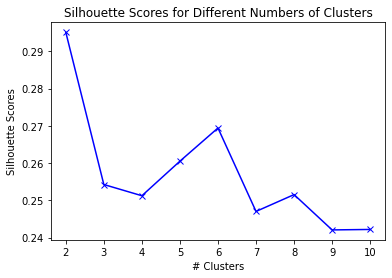

In [30]:
# List of Silhouette Scores for KMeans model
s_scores_km = []
num_clusters_to_iter = range(2, 11)

# Finding the optimal number of cluster for the KMeans appraoch
for k in num_clusters_to_iter:
    
    # Building the clustering model 
    km_model = KMeans(n_clusters = k)

    # Training the model and Storing the predicted cluster labels
    km_labels = km_model.fit_predict(df_clustering)
    
    # Evaluating the performance 
    s_scores_km.append(silhouette_score(df_clustering, km_labels))

print(s_scores_km)

plt.plot(range(2,11), s_scores_km, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()

#### Plot the elbow curve of the distortion that each cluster number gives

In [ ]:
plt.plot(num_clusters_to_iterate, distortions, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method displaying the optimal number of clusters')
plt.show()

## Silhouette Scores for Spectral Clustering algorithm

[0.29512958858192134, 0.2534970159912942, 0.21487469022831432, 0.2384824882187726, 0.08464472121418931, 0.230062961545574, 0.23211173577006772, 0.21372259860106319, 0.21726827717565467]


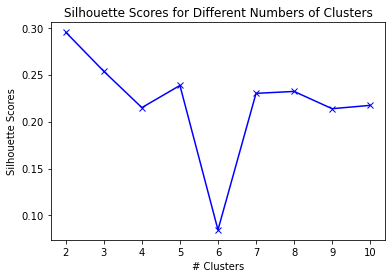

In [31]:
# List of Silhouette Scores for Spectral method with affinity rbf
s_scores_rbf = []
num_clusters_to_iter = range(2, 11)

# Finding the optimal number of cluster for the rbf basis appraoch
for k in num_clusters_to_iter:
    
    # Building the clustering model 
    spectral_model_rbf = SpectralClustering(n_clusters = k, affinity ='rbf')

    # Training the model and Storing the predicted cluster labels
    labels_rbf = spectral_model_rbf.fit_predict(df_clustering)
    
    # Evaluating the performance 
    s_scores_rbf.append(silhouette_score(df_clustering, labels_rbf))

print(s_scores_rbf)

plt.plot(range(2,11), s_scores_rbf, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()

[0.29512958858192134, 0.25576500302229266, 0.2437643549631677, 0.24603325864533168, 0.23242006686111438, 0.2371155387821377, 0.21224274296652562, 0.1961069405018411, 0.18732183675207448]


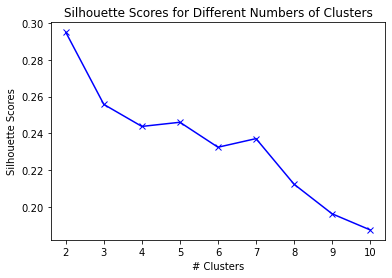

In [33]:
# List of Silhouette Scores for Spectral method with affinity nn
s_scores_nn = []
num_clusters_to_iter = range(2, 11)

# Finding the optimal number of clusters for the nearest_neighbor appraoch
for k in num_clusters_to_iter:
    
    # Building the clustering model 
    spectral_model_nn = SpectralClustering(n_clusters = k, affinity ='nearest_neighbors')

    # Training the model and storing the predicted cluster labels
    labels_nn = spectral_model_nn.fit_predict(df_clustering)
    
    # Evaluating the performance 
    s_scores_nn.append(silhouette_score(df_clustering, labels_nn))

print(s_scores_nn)

plt.plot(range(2,11), s_scores_nn, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()

From the Silhouette scores displayed above, it's clear that there is two distinct groups present in the dataset, which intuitively should represent the 'young' and 'old' subjects in the dataset. The Silhouette Coefficient is the exact same across the three models using two clusters, therefore any model can be used. We will test the Spectral Clustering with rbf algorithm using two clusters.

In [ ]:
#Do Spectral with 2 clusters
#Check which group each subject falls into. If it's 'young' and 'old', then try more clusters.

kmeans = KMeans(n_clusters=2).fit(standard_train_array)
centroids = kmeans.cluster_centers_

In [ ]:
#Choose more clusters
#The next most suitable combination of num_clusters/model is kmeans with 6 clusters
#Confirm this with elbow curve

kmeans = KMeans(n_clusters=6).fit(standard_train_array)
centroids = kmeans.cluster_centers_

# =============================================================

# 4. Cluster the data

# =============================================================

### Use the above graph to set the number of clusters

In [ ]:
num_clusters = 8

## Find out which of the clusters each df row is in

#### Cluster the data

In [ ]:
clustering = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", random_state=0).fit(standard_train_array)
clusters_label = pd.DataFrame(clustering.labels_).rename(columns={0: "Cluster"})

#### Calculate the centroids of the clusters

In [ ]:
kmeans = KMeans(n_clusters=num_clusters).fit(standard_train_array)
centroids = kmeans.cluster_centers_

#### Add a new column to the original data with the cluster each row is in

In [ ]:
full_df_nd_cluster = pd.concat([original_df, clusters_label], axis=1)

In [ ]:
full_df_nd_cluster.head()

# =============================================================

# 5. Principal Component Analysis

# =============================================================

There are eight parameters in this model so principal component analysis is performed below on the data before performing Spectral clustering.

#### Inspect dataframe which PCA is being performed on

In [ ]:
original_df.head()

#### Use PCA to project the data to 2 dimensions

In [ ]:
pca = PCA(n_components=2)

principal_components_array = pca.fit_transform(standard_train_array)

#### Look at how much variance these 2 axes explain

In [ ]:
pca.explained_variance_ratio_

#### Add these principal component columns to the rest of the data

In [ ]:
principal_df = pd.DataFrame(data = principal_components_array, columns = ['Principal_Component_1', 'Principal_Component_2'])
principal_df.head()

In [ ]:
final_df = pd.concat([full_df_nd_cluster, principal_df], axis = 1)

In [ ]:
final_df.head()

# =============================================================

# 6. Plot the clusters with the PCA axes

# =============================================================

## Plot the clusters

#### Choose the columns to plot

In [ ]:
pc1 = final_df['Principal_Component_1']
pc2 = final_df['Principal_Component_2']
group = final_df["group"]
cluster = final_df["Cluster"]

#### Visualise 2D projection

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Plotting the dataset accross the 2 principal components', fontsize = 20)

targets = ['young', 'old']
colors = ['b', 'y']

for target, color in zip(targets, colors):
    ax.scatter(pc1.loc[target == group], pc2.loc[target == group], c = color, s = 50)
    
ax.legend(targets)
ax.grid()

#### Plot the original data

In [ ]:
plt.scatter(pc1, pc2)

#### Plot the data colouring the different groups

In [ ]:
plt.scatter(pc1, pc2, c=np.where(0, 1, group=="young"), s=50)

#### Plot this data colouring the different clusters

In [ ]:
plt.scatter(pc1, pc2, c=cluster, s=50)

#### Plot this data with the clusters and their centroids

In [ ]:
plt.scatter(pc1, pc2, c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

# =============================================================

# 7. Analyse the clusters

# =============================================================

## See how the 'Old' and 'Young' fall into these clusters

In [ ]:
final_df.head()

#### Create a dataframe showing how many people people fell into each cluster

In [ ]:
all_cluster_df = pd.DataFrame(final_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "All"})

#### Change 'young' to 1 and 'old' to np.nan

In [ ]:
final_df["group"] = final_df["group"].replace('old', np.nan).replace('young', 1)

#### Create a dataframe showing how many young people fell into each cluster

In [ ]:
young_cluster_df = pd.DataFrame(final_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "Young"})

#### Create a dataframe showing how many old people fell into each cluster

In [ ]:
old_cluster_df = pd.DataFrame(final_df["group"].isnull().groupby(final_df["Cluster"]).sum().astype(int)).rename(columns={"group": "Old"})

#### Output how many 'young' and 'old' people fell into each cluster

In [ ]:
pd.merge(all_cluster_df, pd.merge(young_cluster_df, old_cluster_df, how="inner", on="Cluster"), how="inner", on="Cluster")